# Treinamento Python - pt2

<br>

Falaremos dos seguintes pontos:

* teamcapcodes 
    * estrutura geral
    * análise de "bivariadas"
* Sklearn
    * estrutura geral do pacote
    * transformers
    * Classificadores
    * Avaliação de modelos
    * Funções auxiliares para fluxo de treino/avaliação de modelos
* statsmodels [https://www.statsmodels.org/stable/index.html] (modelagem estatística)
    
Para replicação, é necessária a instalação dos seguintes pacotes via pip: numpy, pandas, matplotlib, getpass, sklearn, category_encoders. Além desses, o teamcapcodes será enviado via arquivo zipado para instalação.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import teamcapcodes as tcc

from getpass import getpass
from inspect import getsource

# Base Santander

In [2]:
con = tcc.getConn('eric.barbosa', getpass())

········


In [3]:
df = pd.read_sql('''
    select 
        * 
    from est_report.o2o.dm_pedidos_o2o_financeiras
    where
        entidade_id in (109879, 109186, 109835)
        and grupo_controle = 1
        and status_id_atual in (9,10,22)
        and year(pedido_data) = 2020 
        and month(pedido_data) = 3
''', con)

In [4]:
df.columns = df.columns.str.lower()
print(df.shape)
df.head(2)

(16803, 91)


,pedido_id,pedido_codigo_entidade,entidade_id,entidade_nome,pessoa_nome,pedido_origem,pedido_origem2,pedido_obs,contabilizado_cs,pedido_registro,...,escolaridade,nome_da_mae,token_email,token_sms,variavel_resposta,cbk,patrimonio,versao_dm,data_marcacao_cbk,data_marcacao_var
0,732606376.0,62055003222156689,109186.0,SantanderContas,ANGELA REGINA PEREIRA FERREIRA,None,None,None,1,2018-01-09 08:59:21.193,...,ENSINO MEDIO/TECNICO INCOMPLETO,Maria Patrocina Alves da Silva,None,None,0,0,0,2020-03-08 07:12:45.517,None,NaT
1,847735763.0,222341535341129890,109186.0,SantanderContas,FABIANO PEREIRA,None,None,None,1,2018-08-29 20:29:23.990,...,ENSINO MEDIO/TECNICO COMPLETO,Neuza Gonçalves,None,None,0,0,60000,2020-03-04 09:33:22.623,None,NaT


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16803 entries, 0 to 16802
Data columns (total 91 columns):
pedido_id                         16803 non-null float64
pedido_codigo_entidade            16803 non-null object
entidade_id                       16803 non-null float64
entidade_nome                     16803 non-null object
pessoa_nome                       16799 non-null object
pedido_origem                     12757 non-null object
pedido_origem2                    2908 non-null object
pedido_obs                        2907 non-null object
contabilizado_cs                  16803 non-null int64
pedido_registro                   16803 non-null datetime64[ns]
pedido_data                       16803 non-null datetime64[ns]
cpf_cnpj                          16803 non-null object
situacao_cadastral_id             15720 non-null float64
pessoa_nascimento                 16803 non-null datetime64[ns]
pessoa_sexo                       16600 non-null object
cpf_cnpj_conhecido         

In [6]:
# criando variável resposta APV vs FRD ou SUS

df['anomes'] = df['pedido_data'].dt.strftime('%d/%m')
df['y'] = df['status_id_atual'].map(lambda x: 0 if x == 9 else 1)

print('Distribuição da flag de fraude por entidade:')
(100 * df.groupby(['entidade_nome']).y.value_counts(normalize=True).to_frame()).round(2)

Distribuição da flag de fraude por entidade:


y
entidade_nome           y       
SantanderCartoesWay     0  90.49
                        1   9.51
SantanderContas         0  96.09
                        1   3.91
SantanderFinanciamentos 0  95.12
                        1   4.88

# teamcapcodes as tcc

Temos 3 módulos:

* tcc - contém a classe para análise de "bivariada" statisticalVariable
* tcc.utils - funções auxiliares
* tcc.posmod - funções para avaliação de modelos

## Análise bivariada

Com base na variável resposta 'y', queremos ver o risco relativo de fraude para diferentes situações de uma variável. 

Vamos analisar primeiro a variável já disponibilizada na tabela: `mp_telqualquerendqualquer`, e depois uma análise da `escolaridade`

### MP

In [7]:
df['mp_telqualquerendqualquer'].value_counts(dropna=False).sort_index()

0       11706
1         334
2         640
3         513
4           1
12        420
13        393
14          2
23       1053
24          3
34          4
123      1496
124        13
134        11
234        67
1234      147
Name: mp_telqualquerendqualquer, dtype: int64

In [8]:
df['mp_telend'] = df['mp_telqualquerendqualquer'].map(lambda x: 1 if x > 0 else 0)

In [110]:
sv = tcc.statisticalVariable(
    data=df,
    categories='mp_telend', # variavel a ser analisada
    status='y',
    time=None, # coluna de tempo/safra para análise longitudinal
    groups=[], # coluna(s) de agrupamento da análise
    statusCustom=None, # se 'status' já é 0/1, pode ignorar esse parametro
)

In [111]:
sv.bivariadaTable()

,Variavel,Group,Category,Total,proporcao,Y,proporcaoMaus,txY,WoE,IV
0,mp_telend,Geral,0,11706,69.67%,1140,92.16%,9.74%,0.31,0.07
1,mp_telend,Geral,1,5097,30.33%,97,7.84%,1.90%,-1.41,0.34


Agora, inicializando com estratos:

In [113]:
sv = tcc.statisticalVariable(
    data=df,
    categories='mp_telend', # variavel a ser analisada
    status='y',
    time=None, # coluna de tempo/safra para análise longitudinal
    groups=['entidade_nome'], # coluna(s) de agrupamento da análise
    statusCustom=None, # se 'status' já é 0/1, pode ignorar esse parametro
)

In [114]:
sv.bivariadaTable()

,Variavel,Group,Category,Total,proporcao,Y,proporcaoMaus,txY,WoE,IV
0,mp_telend,SantanderCartoesWay,0,7140,72.49%,885,94.45%,12.39%,0.30,0.07
1,mp_telend,SantanderCartoesWay,1,2709,27.51%,52,5.55%,1.92%,-1.68,0.41
2,mp_telend,SantanderContas,0,2987,73.83%,145,91.77%,4.85%,0.23,0.04
3,mp_telend,SantanderContas,1,1059,26.17%,13,8.23%,1.23%,-1.18,0.22
4,mp_telend,SantanderFinanciamentos,0,1579,54.30%,110,77.46%,6.97%,0.38,0.09
5,mp_telend,SantanderFinanciamentos,1,1329,45.70%,32,22.54%,2.41%,-0.73,0.18


Pode filtrar a tabela bivariada para níveis em particular com o parâmetro `groupsInteresse`. Além disso, para reter o resultado como um pd.DataFrame, utilizar argumento `getDF=True`

In [115]:
sv.bivariadaTable(groupsInteresse={'entidade_nome': ['SantanderFinanciamentos',
                                                     'SantanderContas']}, 
                  getDF=True)

,Variavel,Group,Category,Total,proporcao,Y,proporcaoMaus,txY,WoE,IV
0,mp_telend,SantanderContas,0,2987,73.826001,145,91.772152,4.854369,0.227526,0.042491
1,mp_telend,SantanderContas,1,1059,26.173999,13,8.227848,1.227573,-1.184724,0.221252
2,mp_telend,SantanderFinanciamentos,0,1579,54.298487,110,77.464789,6.966434,0.377474,0.091936
3,mp_telend,SantanderFinanciamentos,1,1329,45.701513,32,22.535211,2.407825,-0.732743,0.178464


### Escolaridade

Essa informaão possui muitas categorias. Provavelmente teremos que agrupar para poder analisar.

In [14]:
df['escolaridade'].value_counts(dropna=False)

ENSINO MEDIO COMPLETO                 4999
NaN                                   2911
FUNDAMENTAL COMPLETO                  2158
SUPERIOR EM CURSO OU COMPLETO         1406
ENSINO MEDIO/TECNICO COMPLETO         1241
ENSINO FUNDAMENTAL COMPLETO            851
MEDIO/TECNICO COMPLETO                 598
ENSINO FUNDAMENTAL INCOMPLETO          582
ENSINO MEDIO/TECNICO INCOMPLETO        461
SUPERIOR INCOMPLETO                    457
SUPERIOR COMPLETO                      431
POS-GRADUACAO EM CURSO OU COMPLETA     284
SEM ESCOLARIDADE                       235
POS-GRADUACAO COMPLETA                  93
MESTRADO EM CURSO OU COMPLETO           33
POS-GRADUACAO INCOMPLETA                29
MESTRADO COMPLETO                       11
DOUTORADO EM CURSO OU COMPLETO           9
MESTRADO INCOMPLETO                      7
DOUTORADO COMPLETO                       4
DOUTORADO INCOMPLETO                     3
Name: escolaridade, dtype: int64

In [116]:
df['escolaridade'].fillna('na', inplace=True)
sv = tcc.statisticalVariable(df, 'escolaridade', 'y')

In [118]:
# sv.bivariadaTable()

Sendo assim, vamos criar alguns agrupamentos... 

In [17]:
from teamcapcodes.utils import collapseCat

In [119]:
agg_baixafreq = collapseCat(df['escolaridade'], threshold=0.1, into='ELSE')

In [120]:
agg_nivel = collapseCat(df['escolaridade'], 
                        mapping={'pos': re.compile('(DOUTORADO)|(MESTRADO)|(POS-GRADUACAO)'),
                                 'faculdade': re.compile('(SUPERIOR)'),
                                 'fundamental': re.compile('(FUNDAMENTAL)'),
                                 'medio/tecnico': re.compile('(MEDIO)'),
                                 'sem info': ['na', 'SEM ESCOLARIDADE']})

In [123]:
tcc.statisticalVariable(df, agg_baixafreq, 'y').bivariadaTable()

,Variavel,Group,Category,Total,proporcao,Y,proporcaoMaus,txY,WoE,IV
0,variavel_teste,Geral,ELSE,6735,40.08%,432,34.92%,6.41%,-0.15,0.01
1,variavel_teste,Geral,ENSINO MEDIO COMPLETO,4999,29.75%,367,29.67%,7.34%,-0.00,0.00
2,variavel_teste,Geral,FUNDAMENTAL COMPLETO,2158,12.84%,295,23.85%,13.67%,0.69,0.08
3,variavel_teste,Geral,na,2911,17.32%,143,11.56%,4.91%,-0.43,0.03


In [122]:
tcc.statisticalVariable(df, agg_nivel, 'y', groups=['entidade_nome']) \
    .bivariadaTable()

,Variavel,Group,Category,Total,proporcao,Y,proporcaoMaus,txY,WoE,IV
0,variavel_teste,SantanderCartoesWay,faculdade,1540,15.64%,107,11.42%,6.95%,-0.34,0.02
1,variavel_teste,SantanderCartoesWay,fundamental,2158,21.91%,295,31.48%,13.67%,0.41,0.04
2,variavel_teste,SantanderCartoesWay,medio/tecnico,5597,56.83%,432,46.10%,7.72%,-0.23,0.03
3,variavel_teste,SantanderCartoesWay,pos,351,3.56%,39,4.16%,11.11%,0.17,0.00
4,variavel_teste,SantanderCartoesWay,sem info,203,2.06%,64,6.83%,31.53%,1.48,0.08
5,variavel_teste,SantanderContas,faculdade,754,18.64%,17,10.76%,2.25%,-0.57,0.05
6,variavel_teste,SantanderContas,fundamental,1433,35.42%,64,40.51%,4.47%,0.14,0.01
7,variavel_teste,SantanderContas,medio/tecnico,1702,42.07%,67,42.41%,3.94%,0.01,0.00
8,variavel_teste,SantanderContas,pos,122,3.02%,3,1.90%,2.46%,-0.48,0.01
9,variavel_teste,SantanderContas,sem info,35,0.87%,7,4.43%,20.00%,1.82,0.07


# sklearn 

Tópicos:

* estrutura geral do pacote
* transformers
* Classificadores
* Avaliação de modelos
* Funções auxiliares para fluxo de treino/avaliação de modelos

<br>

Principais módulos:

* [https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model]
* [https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics]
* [https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection]
* [https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing]

Apresentação do pacote

## transformers 

O módulo sklearn.preprocessing contém classes e funções para a transformação e adequação de dados para a etapa de modelagem em inúmeros sentidos: transformações contínuas, normalizações, encoders, etc. Suas classes seguem o fluxo `.fit() -> .transform()`. Aqui, vou falar de 3:

* OneHotEncoder - cria matriz com variáveis dummy para cada nível da feature
* StandardScaler - padronização para obter dados com média 0 e variância 1
* WOEEncoder - transformação Weight of Evidence para par (feature, target01)
* PolynomialFeatures - permite interagir variáveis e gerar outras com suas potências

A vantagem de usar estas classes é que são otimizadas internamente e aplicam as transformações a cada elemento de uma matriz de input.

In [22]:
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler, scale,
                                   PolynomialFeatures)
from category_encoders import WOEEncoder

In [23]:
std = StandardScaler(with_mean=True, with_std=True)
one = OneHotEncoder(categories='auto', drop=None, sparse=False)
woe = WOEEncoder(regularization=0)

### StandardScaler

Para cada coluna da matriz de input X, tira sua média e divide pelo seu desvio padrão. Pode ser usada tanto com a classe `StandardScaler` como com a função `scale`

In [24]:
std.fit_transform(df[['idade','tempo_analise','quantidade_de_reanalises','renda']].astype(float))

array([[ 0.42067147, -0.10577063,  2.87601743, -0.01163857],
       [-0.34672251,  0.91899074,  5.29787374, -0.01157903],
       [-0.5769407 ,  0.88396056,  6.91244461, -0.01163432],
       ...,
       [-0.26998311, -0.63322805, -0.35312432, -0.01157903],
       [ 0.65088966,  0.73677667, -0.35312432, -0.01162156],
       [-0.8071589 ,  0.43837872, -0.35312432, -0.01149396]])

### OneHotEncoder, pd.get_dummies

In [25]:
df['entidade_nome'].value_counts()

SantanderCartoesWay        9849
SantanderContas            4046
SantanderFinanciamentos    2908
Name: entidade_nome, dtype: int64

In [26]:
entidade_nome_onehot = one.fit_transform(df[['entidade_nome']])
print(entidade_nome_onehot.shape)
entidade_nome_onehot

(16803, 3)


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [27]:
entidade_nome_onehot.sum(axis=0)

array([9849., 4046., 2908.])

Apesar de ser mais difícil de trabalhar, a classe OneHotEncoder é uma alternativa mais escalável à função pd.get_dummies (possui representação esparsa). Além disso, possui uma melhor interação com as outras funções do sklearn. Mesmo assim, segue comparação com pd.get_dummies:

In [28]:
entidade_nome_dummies = pd.get_dummies(df['entidade_nome'])
entidade_nome_dummies.sample(5)

,SantanderCartoesWay,SantanderContas,SantanderFinanciamentos
7149,1,0,0
13702,1,0,0
15757,1,0,0
3855,0,1,0
11880,1,0,0


Checando igualdade:

In [29]:
(entidade_nome_onehot == entidade_nome_dummies.values).all()

True

### PolynomialFeatures

Primeira utilidade: interação entre variáveis

In [30]:
inter = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [31]:
df.renda.astype(float).head()

0    1100.0
1    2500.0
2    1200.0
3    1650.0
4    1700.0
Name: renda, dtype: float64

In [32]:
df['idade'] = df['idade'].fillna(18)
df['renda'] = df['renda'].astype(float).fillna(0)

idade_renda = inter.fit_transform(df[['idade','renda']])

In [33]:
idade_renda

array([[4.100e+01, 1.100e+03, 4.510e+04],
       [3.100e+01, 2.500e+03, 7.750e+04],
       [2.800e+01, 1.200e+03, 3.360e+04],
       ...,
       [3.200e+01, 2.500e+03, 8.000e+04],
       [4.400e+01, 1.500e+03, 6.600e+04],
       [2.500e+01, 4.500e+03, 1.125e+05]])

In [34]:
pd.DataFrame(idade_renda, columns=['idade','renda','idade:renda']).head()

,idade,renda,idade:renda
0,41.0,1100.0,45100.0
1,31.0,2500.0,77500.0
2,28.0,1200.0,33600.0
3,26.0,1650.0,42900.0
4,39.0,1700.0,66300.0


Segunda opção: x^2, x^3, etc

In [35]:
sqrd = PolynomialFeatures(degree=2, include_bias=True)

In [36]:
pd.DataFrame(sqrd.fit_transform(df[['idade']]), columns=['intercepto','idade','idade**2']).head()

,intercepto,idade,idade**2
0,1.0,41.0,1681.0
1,1.0,31.0,961.0
2,1.0,28.0,784.0
3,1.0,26.0,676.0
4,1.0,39.0,1521.0


### WOEEncoder

Classe muito útil para gerar target encoder WOE em múltiplas variáveis de forma vetorizada. Não vem nativamente do sklearn, mas de um pacote auxiliar chamado category_encoders. Apesar disso, possui chamada de métodos equivalente (`.fit() -> .transform()`)

In [124]:
woe = WOEEncoder(regularization=0)

In [125]:
help(woe)

Help on WOEEncoder in module category_encoders.woe object:

class WOEEncoder(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  WOEEncoder(verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, randomized=False, sigma=0.05, regularization=1.0)
 |  
 |  Weight of Evidence coding for categorical features.
 |  
 |  Parameters
 |  ----------
 |  
 |  verbose: int
 |      integer indicating verbosity of the output. 0 for none.
 |  cols: list
 |      a list of columns to encode, if None, all string columns will be encoded.
 |  drop_invariant: bool
 |      boolean for whether or not to drop columns with 0 variance.
 |  return_df: bool
 |      boolean for whether to return a pandas DataFrame from transform (otherwise it will be a numpy array).
 |  handle_unknown: str
 |      options are 'return_nan', 'error' and 'value', defaults to 'value', which will assume WOE=0.
 |  randomized: bool,
 |      adds normal (Ga

Note que o método `.fit`, para este caso, necessita da variável resposta além da matriz de features.

In [38]:
help(woe.fit)

Help on method fit in module category_encoders.woe:

fit(X, y, **kwargs) method of category_encoders.woe.WOEEncoder instance
    Fit encoder according to X and binary y.
    
    Parameters
    ----------
    
    X : array-like, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples
        and n_features is the number of features.
    y : array-like, shape = [n_samples]
        Binary target values.
    
    Returns
    -------
    
    self : encoder
        Returns self.



In [126]:
df['idade_cat'] = pd.qcut(df['idade'], q=5)
df['renda_cat'] = pd.qcut(df['renda'], q=5)

In [127]:
df['idade_cat'].value_counts().sort_index()

(-0.001, 24.0]    3699
(24.0, 30.0]      3115
(30.0, 37.0]      3453
(37.0, 46.0]      3317
(46.0, 120.0]     3219
Name: idade_cat, dtype: int64

In [128]:
df['renda_cat'].value_counts().sort_index()

(-0.001, 1004.2]          3361
(1004.2, 1500.0]          4178
(1500.0, 2000.0]          3136
(2000.0, 3000.0]          2998
(3000.0, 2500000000.0]    3130
Name: renda_cat, dtype: int64

In [42]:
df.anomes.value_counts(normalize=True).sort_index().cumsum()

01/03    0.028745
02/03    0.084628
03/03    0.136702
04/03    0.188181
05/03    0.236684
06/03    0.279176
07/03    0.314349
08/03    0.336309
09/03    0.387193
10/03    0.446349
11/03    0.507528
12/03    0.564364
13/03    0.614057
14/03    0.648872
15/03    0.674879
16/03    0.727906
17/03    0.768137
18/03    0.779385
19/03    0.788907
20/03    0.795513
21/03    0.796703
22/03    0.797715
23/03    0.803130
24/03    0.828364
25/03    0.848896
26/03    0.872344
27/03    0.893352
28/03    0.907159
29/03    0.919360
30/03    0.953758
31/03    1.000000
Name: anomes, dtype: float64

In [43]:
treino = df['pedido_data'] <= '20200323'

In [129]:
dftr = df[treino]
dftt = df[~treino]
vars_woe = ['idade_cat','renda_cat']

In [130]:
woe.fit(dftr[vars_woe].astype(str), dftr['y'])

WOEEncoder(cols=['idade_cat', 'renda_cat'], drop_invariant=False,
           handle_missing='value', handle_unknown='value', random_state=None,
           randomized=False, regularization=0, return_df=True, sigma=0.05,
           verbose=0)

In [133]:
woe.mapping

{'idade_cat': idade_cat
  1   -0.252719
  2   -0.456655
  3   -0.401998
  4    0.575035
  5    0.175094
 -1    0.000000
 -2    0.000000
 dtype: float64, 'renda_cat': renda_cat
  1    0.197401
  2    0.147347
  3   -0.086971
  4   -0.371317
  5    0.024550
 -1    0.000000
 -2    0.000000
 dtype: float64}

In [134]:
# base de treino
woe.transform(dftr[vars_woe].astype(str)).head()

,idade_cat,renda_cat
0,-0.252719,0.197401
1,-0.456655,0.147347
2,-0.401998,0.197401
3,-0.401998,-0.086971
5,0.575035,0.147347


In [135]:
# base de teste
woe.transform(dftt[vars_woe].astype(str)).head()

,idade_cat,renda_cat
4,-0.252719,-0.086971
9,-0.401998,-0.086971
17,0.575035,0.024550
19,-0.252719,-0.371317
25,-0.456655,0.024550


Importante: como saber qual foi o mapping de WOE na base de treino?

In [136]:
cat_woe = pd.concat([
    dftr[vars_woe],
    woe.transform(dftr[vars_woe].astype(str)).add_prefix('woe_')
], axis=1).drop_duplicates()

In [137]:
(cat_woe[['idade_cat','woe_idade_cat']]
 .drop_duplicates()
 .sort_values(by='woe_idade_cat'))

,idade_cat,woe_idade_cat
1,"(30.0, 37.0]",-0.456655
2,"(24.0, 30.0]",-0.401998
0,"(37.0, 46.0]",-0.252719
10,"(-0.001, 24.0]",0.175094
5,"(46.0, 120.0]",0.575035


In [50]:
(cat_woe[['renda_cat','woe_renda_cat']]
 .drop_duplicates()
 .sort_values(by='woe_renda_cat'))

,renda_cat,woe_renda_cat
13,"(-0.001, 1004.2]",-0.371317
3,"(1500.0, 2000.0]",-0.086971
23,"(3000.0, 2500000000.0]",0.024550
1,"(2000.0, 3000.0]",0.147347
0,"(1004.2, 1500.0]",0.197401


## Modelos

Detalhe: aqui, para estimação dos modelos, são aplicados algoritmos sob a perspectiva de otimização, e não estatística. Assim, este módulo não fornece análise de p-valor, distribuição de parâmetros, entre outros. Para análises estatísticas (incluindo modelos lineares generalizados), recomendo o pacote `statsmodels`. 

Os modelos do sklearn estão espalhados por diferentes módulos, de acordo com a sua natureza (lineares, árvores, ensembles). Dentro de cada módulo, as classes são divididas por tipo de resposta que quer modelar (regressão ou classificação). Todas as classes seguem o paradigma `.fit() -> .predict()`. 
<br>

Módulos com tipos de modelos:

* sklearn.linear_model - LinearRegression, LogisticRegression
* sklearn.tree - DecisionTreeClassifier, DecisionTreeRegressor
* sklearn.ensemble - RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, etc

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [81]:
lr = LogisticRegression(penalty='l2', # ['l1','l2'], ridge regression
    C=1.0, # quanto maior, menor a regularização
    dual=False,
    tol=0.0001,                        
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None
)

In [82]:
dt = DecisionTreeClassifier(criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort='deprecated',
    ccp_alpha=0.0)

In [83]:
rf = RandomForestClassifier(n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

In [138]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
xtr = dftr[['mp_telend','idade_cat','renda_cat']].astype(str); ytr = dftr['y']
xtt = dftt[['mp_telend','idade_cat','renda_cat']].astype(str); ytt = dftt['y']

In [140]:
woe = WOEEncoder(regularization=0).fit(xtr,ytr)
xtr = woe.transform(xtr)
xtt = woe.transform(xtt)

In [141]:
lr = lr.fit(xtr,ytr)
dt = dt.fit(xtr,ytr)

In [88]:
lr.predict(xtt)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Observação: nem todo modelo tem opção de retornar as probabilidades

In [89]:
lr.predict_proba(xtt)

array([[0.92800964, 0.07199036],
       [0.93703919, 0.06296081],
       [0.8416258 , 0.1583742 ],
       ...,
       [0.98359344, 0.01640656],
       [0.91123356, 0.08876644],
       [0.93156034, 0.06843966]])

### Avaliando betas da Regressão logística

In [90]:
print(lr.coef_[0])
lr.intercept_[0]

[0.93208827 0.96264164 0.8007794 ]


-2.530750751138654

In [91]:
betas = pd.DataFrame({'variaveis': ['intercepto'] + xtr.columns.tolist(),
                      'betas': [lr.intercept_[0]] + lr.coef_[0].tolist()})
betas

,variaveis,betas
0,intercepto,-2.530751
1,mp_telend,0.932088
2,idade_cat,0.962642
3,renda_cat,0.800779


## Avaliação de modelos

Indicadores gerais de modelagem podem ser encontrados no módilo `sklearn.metrics`:

* accuracy (não recomendado para targets não balanceados) 
* roc_auc_score
* f1_score
* confusion_matrix
<br>

Indicadores comuns à Clearsale (KS, CSIx) podem ser gerados com as funções dentro do `teamcapcodes.posmod`:

* makeTabelao
* plotTabelao

### Métricas tradicionais

In [92]:
from sklearn import metrics

In [93]:
metrics.confusion_matrix(ytt, lr.predict(xtt))

array([[3152,    0],
       [ 247,    0]], dtype=int64)

In [94]:
metrics.f1_score(ytt, lr.predict(xtt))

0.0

In [95]:
print(metrics.classification_report(ytt, lr.predict(xtt), zero_division=0))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3152
           1       0.00      0.00      0.00       247

    accuracy                           0.93      3399
   macro avg       0.46      0.50      0.48      3399
weighted avg       0.86      0.93      0.89      3399



### Clearsale

In [96]:
from teamcapcodes.posmod import * #makeTabelao, plotTabelao

In [142]:
tabelao = makeTabelao(ytt, lr.predict_proba(xtt)[:,1], n=10)
tabelao

,quebras,score_min,score_max,total,total_maus,total_bons,tx_maus,p_maus,p_maus_acum,p_bons_acum,expos
0,0,0.010961,0.016503,340,5,335,0.014706,0.020243,1.000000,1.000000,0.014706
1,1,0.016503,0.024903,340,3,337,0.008824,0.012146,0.979757,0.893718,0.008824
2,2,0.024903,0.058367,340,9,331,0.026471,0.036437,0.967611,0.786802,0.026471
3,3,0.058367,0.068637,340,21,319,0.061765,0.085020,0.931174,0.681789,0.061765
4,4,0.068637,0.074321,340,20,320,0.058824,0.080972,0.846154,0.580584,0.058824
5,5,0.074321,0.078400,339,28,311,0.082596,0.113360,0.765182,0.479061,0.082596
6,6,0.078400,0.088988,340,26,314,0.076471,0.105263,0.651822,0.380393,0.076471
7,7,0.088988,0.124037,340,34,306,0.100000,0.137652,0.546559,0.280774,0.100000
8,8,0.124037,0.147093,340,38,302,0.111765,0.153846,0.408907,0.183693,0.111765
9,9,0.147093,0.177968,340,63,277,0.185294,0.255061,0.255061,0.087881,0.185294


In [98]:
print('KS: {}'.format((tabelao.p_maus_acum - tabelao.p_bons_acum).abs().max().round(2)))

KS: 0.3


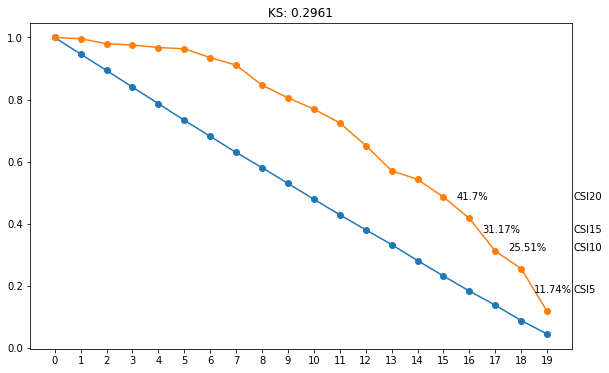

In [99]:
plotTabelao(tabelao)

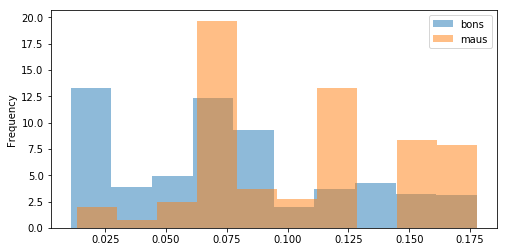

In [100]:
pred = pd.DataFrame({'y': ytt, 'p': lr.predict_proba(xtt)[:,1]})

_, ax = plt.subplots(figsize=(8,4))

pred.query('y==0').p.plot.hist(ax=ax, density=True, label='bons', alpha=0.5)
pred.query('y==1').p.plot.hist(ax=ax, density=True, label='maus', alpha=0.5)

plt.legend()
plt.show()

## Funções auxiliares

### GridSearchCV, RandomizedSearchCV

Classes para performar tunagem de hiperparâmetros dos modelos. Por exemplo, na classe `LogisticRegression`, é possível determinar qual o tipo de regularização dos coeficientes que será aplicada (`penalty`). 

Com o grid search, é possível passar uma série de possíveis valores para que ele faça a avaliação da melhor configuração, dada uma métrica de performance. Para modelos complexos, tomar cuidado com a quantidade de combinações que é passada, pois a busca é exaustiva e pode demorar muito. Neste caso, é mais interessante usar o `RandomizedSearchCV`, que fará uma busca aleatória dentro do grid passado.

Criando métrica customizada: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

In [102]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [103]:
lr = LogisticRegression(solver='liblinear', random_state=42)

In [104]:
grid = {'C': [0.1,1,10], 'penalty': ['l1','l2']}

In [105]:
gs = GridSearchCV(lr, param_grid=grid, cv=5, scoring='auc')

In [106]:
gs.fit(xtr, ytr)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [143]:
aj = gs.best_estimator_

### train_test_split

Faz separação de amostra treino/teste, podendo estratificar e fixar semente para aleatorização. Seu retorno é uma tupla com 4 elementos: `X_train, X_test, Y_train, Y_test`

In [101]:
from sklearn.model_selection import train_test_split

In [107]:
VARS = ['idade_cat','renda_cat','entidade_nome','mp_telend']

xtr, xtt, ytr, ytt = train_test_split(df[VARS], df['y'], test_size=0.3, random_state=42)

In [108]:
print(xtr.shape)
print(ytr.shape)
print(xtt.shape)
print(ytt.shape)

(11762, 4)
(11762,)
(5041, 4)
(5041,)
